# Datasets and Dataloaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: ***torch.utils.data.DataLoader*** and ***torch.utils.data.Dataset*** that allow you to use pre-loaded datasets as well as your own data. 
- Dataset stores the samples and their corresponding labels, and 
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of sample pre-loaded datasets (such as FashionMNIST) that subclass ***torch.utils.data.Dataset*** and implement functions specific to the particular data. They can be found and used as samples for prototyping and benchmarking your model here:

- Image Datasets
- Text Datasets
- Audio Datasets

## Loading a Dataset
We will be loading the ***Fashion-MNIST*** dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

- Each image is 28 pixels in height and 28 pixels in width, with a total of 784 pixels
- The 10 classes tell what type of image it is. For example: T-shirt/top, Trouser, Pullover, Dress, Bag, Ankle boot etc.
- The grayscale are values between 0 to 255 that measure the intensity of black and white images. The intensity value increase from white to black. For example: a white color will be 0, while a black color will 255.
Image show grayscale image pixels and values

We load the FashionMNIST Dataset with the following parameters:

- **root** is the path where the train/test data is stored,
- **train** specifies training or test dataset,
- **download=True** downloads the data from the Internet if it's not available at root.
- **transform** and **target_transform** specify the feature and label transformations

In [2]:
%matplotlib inline

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



## Iterating through the Dataset
We can index Datasets manually like a list: ***training_data[index]***. 

We use matplotlib to visualize some samples in our training data.

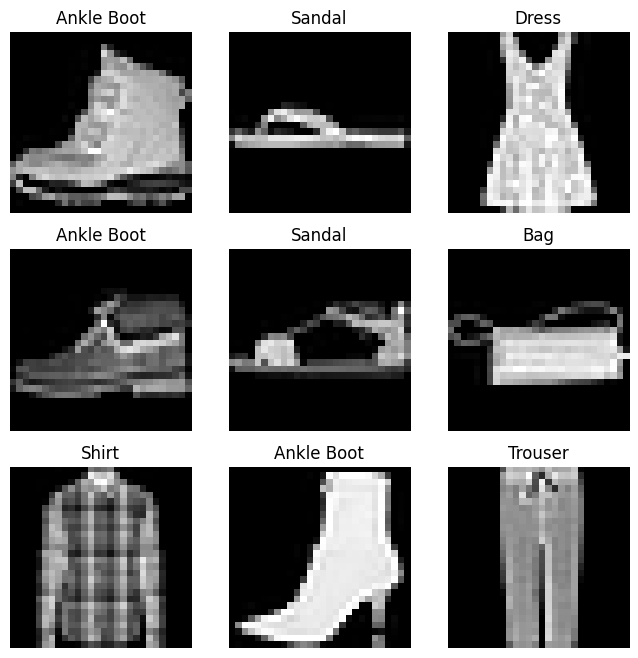

In [14]:
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols,row = 3,3

for i in range (1,cols*row+1):
    sample_idx=torch.randint(len(training_data),size=(1,)).item()
    img,label=training_data[sample_idx]
    figure.add_subplot(row,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze() ,cmap="gray")
    
plt.show()

## Preparing your data for training with DataLoaders

The **Dataset** retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's multiprocessing to speed up data retrieval.

In machine learning, you need to specify what the feature and label are in your dataset. Features are input and labels are output. We train use features and train the model to predict the label.

- Labels are what 10 class types: T-shirt, Sandal, Dress etc
- Features are the patterns in the images pixels


The **DataLoader** is an iterable that abstracts this complexity for us in an easy API. We use the Dataloader, we need to set the following paraments:

- ***data*** the training data that will be used to train the model; and test data to evaluate the model
- ***batch siz***e the number of records to be processed in each batch
- ***shuffle*** the randoms sample of the data by indices

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterating through the DataLoader
We have loaded that dataset into the Dataloader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels(containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


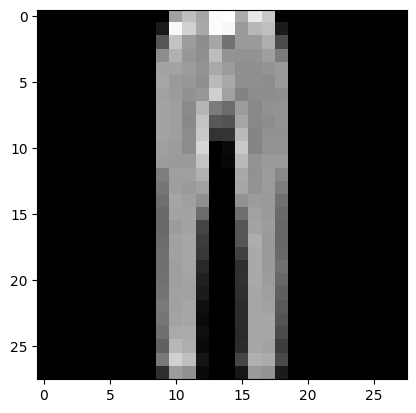

Label: Trouser


In [29]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img=train_features[0].squeeze()
label=train_labels[0]

plt.imshow(img,cmap="gray")
plt.show()

print(f"Label: {labels_map[label.item()]}")

## Normalization

Normalization is a common data pre-processing technique that is applied to scale or transform the data to make sure there's an equal learning contribution from each feature. For example, each pixel in the grayscale images have a value between 0 and 255, which are features. If one pixel value is 17 and another pixel is 197. There will be an uneven distribution of the pixel importance, because the higher pixel volumes will deviate the learning. Normalization changes the range of your data, without distorting its distintion among out feature. This pre-processing is to avoid:

- A reduction of the prediction accuracy
- Difficulty for the model to learn
- Unfavorable distribution of the feature data ranges


### Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters (transform to modify the features and target_transform to modify the labels) that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda

In [35]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10,dtype=torch.float).scatter_(0,torch.tensor(y),value=1))
)

ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

**To Tensor**

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor and scales the image's pixel intensity values in the range [0., 1.]

**Lambda transforms**

Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter which assigns a value=1 on the index as given by the label y. You can also use torch.nn.functional.one_hot as another option to

In [34]:
target_transform=Lambda(lambda y: torch.zeros(10,dtype=torch.float).scatter_(0,torch.tensor(y),value=1))

print(target_transform(1))

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
